In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.15
IPython version      : 7.9.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.1+cu113
transformers: 4.25.1



In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# CUDA (or Compute Unified Device Architecture)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
df_fake = pd.read_csv('./politifact_fake.csv')
df_true = pd.read_csv("./politifact_real.csv")

In [ ]:
df_covid1 = pd.read_csv("./Constraint_Train.csv")
df_covid2 = pd.read_csv("./Constraint_Val.csv")
df_covid1.rename(columns = {'tweet':'title'}, inplace = True)
df_covid2.rename(columns = {'tweet':'title'}, inplace = True)

In [ ]:
df_covid1 = df_covid1.drop('id', axis=1)
df_covid2 = df_covid2.drop('id', axis=1)

In [ ]:
df = pd.concat([df_fake,df_true,df_covid1,df_covid2])
df_title = df.title
df_label = df.label
df = pd.concat([df_title,df_label],1)

<ipython-input-16-8d8b712a343b>:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df = pd.concat([df_title,df_label],1)


In [ ]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [ ]:
df = df.reset_index(drop=True)
df

,title,label
0,BREAKING: First NFL Team Declares Bankruptcy O...,Fake
1,Court Orders Obama To Pay $400 Million In Rest...,Fake
2,UPDATE: Second Roy Moore Accuser Works For Mic...,Fake
3,Oscar Pistorius Attempts To Commit Suicide,Fake
4,Trump Votes For Death Penalty For Being Gay,Fake
...,...,...
9548,Donald Trump wrongly claimed that New Zealand ...,fake
9549,Current understanding is #COVID19 spreads most...,real
9550,Nothing screams “I am sat around doing fuck al...,fake
9551,Birx says COVID-19 outbreak not under control ...,fake


In [ ]:
def to_sentiment(rating):
  rating = str(rating)
  if rating == "Fake" or rating == "fake":
    return 0
  elif rating == "Real" or rating == "real":
    return 1
  else:
    return 2

df['numLabel'] = df.label.apply(to_sentiment)

In [ ]:
df

,title,label,numLabel
0,BREAKING: First NFL Team Declares Bankruptcy O...,Fake,0
1,Court Orders Obama To Pay $400 Million In Rest...,Fake,0
2,UPDATE: Second Roy Moore Accuser Works For Mic...,Fake,0
3,Oscar Pistorius Attempts To Commit Suicide,Fake,0
4,Trump Votes For Death Penalty For Being Gay,Fake,0
...,...,...,...
9548,Donald Trump wrongly claimed that New Zealand ...,fake,0
9549,Current understanding is #COVID19 spreads most...,real,1
9550,Nothing screams “I am sat around doing fuck al...,fake,0
9551,Birx says COVID-19 outbreak not under control ...,fake,0


In [ ]:
class_names = ['Fake', 'Real']

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
token_lens = []

for txt in df.title:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


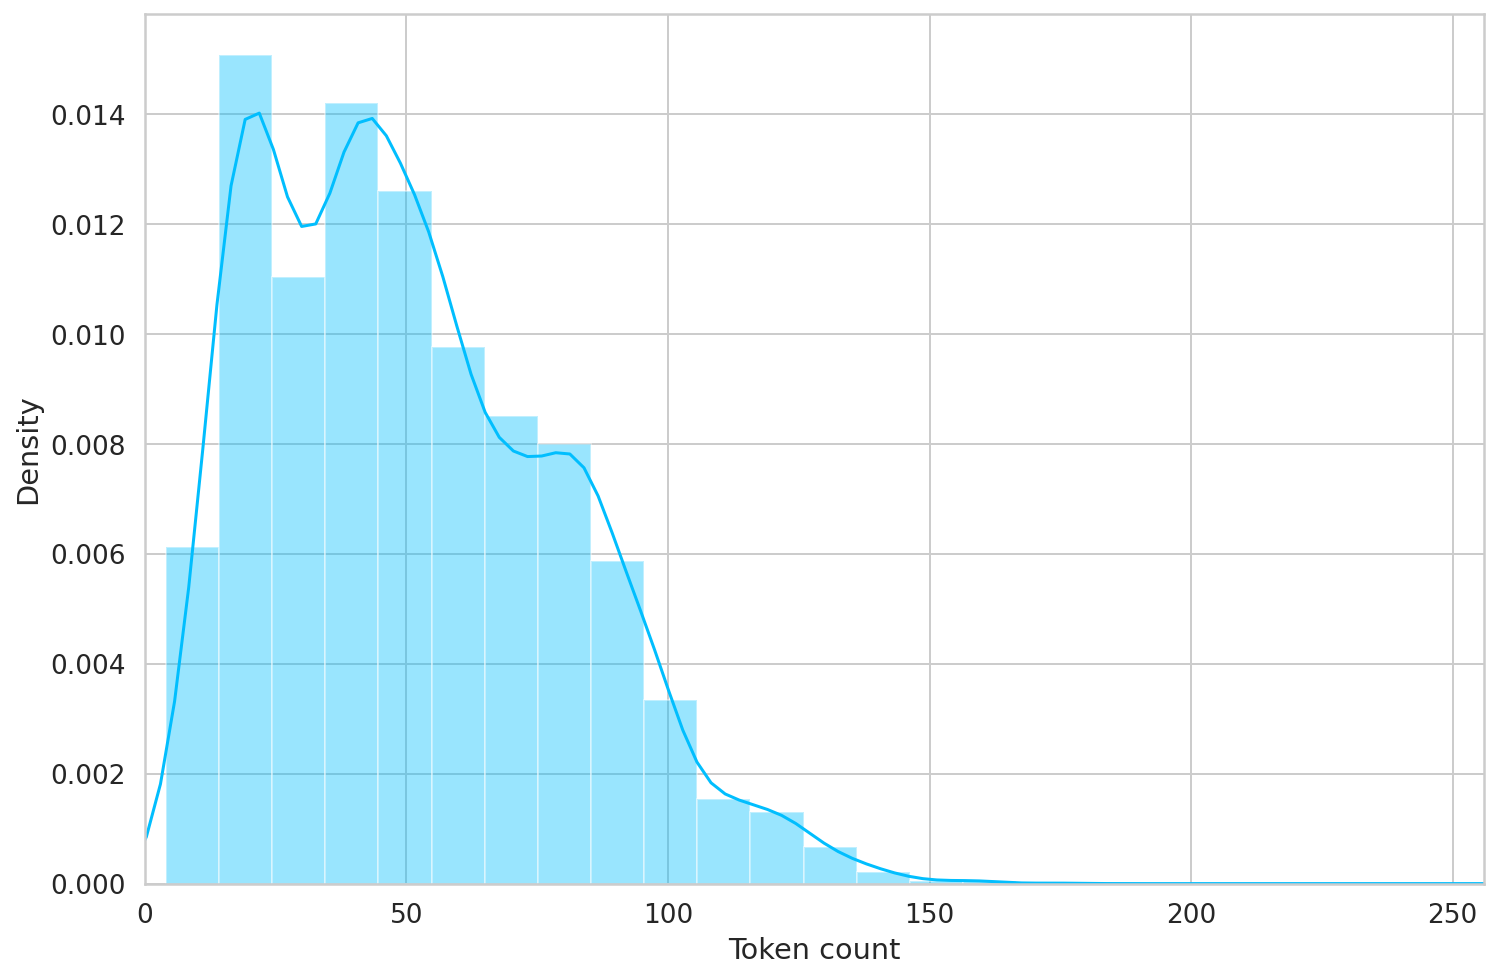

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 150

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.title.to_numpy(),
    targets=df.numLabel.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
df_train

,title,label,numLabel
304,FDA Announced That Vaccines Are Causing Autism,Fake,0
5212,• At Level 2 indoor and outdoor gatherings are...,real,1
2894,The corona test has a completely different pur...,fake,0
474,It’s Time for the Senate to Do Its Job – Congr...,Real,1
2375,The National Coronavirus Emergency Operations ...,real,1
...,...,...,...
5734,Michigan Gov. Gretchen Whitmer “has just been ...,fake,0
5191,Our daily update is published. We’ve now track...,real,1
5390,#IndiaFightsCorona Nearly 74% of the total Act...,real,1
860,The Des Moines Register,Real,1


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    returned = self.bert(
    input_ids=input_ids,
    attention_mask=attention_mask
    )
    pooled_output = returned["pooler_output"]
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


In [ ]:
EPOCHS = 1

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

path = './bertweights_new.pth'

model = torch.load(path)
model.eval()

RuntimeError: ignored

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

0.5355648535564853

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [ ]:
y_pred

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Fake       0.56      0.15      0.24       229
        Real       0.53      0.89      0.67       249

    accuracy                           0.54       478
   macro avg       0.54      0.52      0.45       478
weighted avg       0.54      0.54      0.46       478



In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

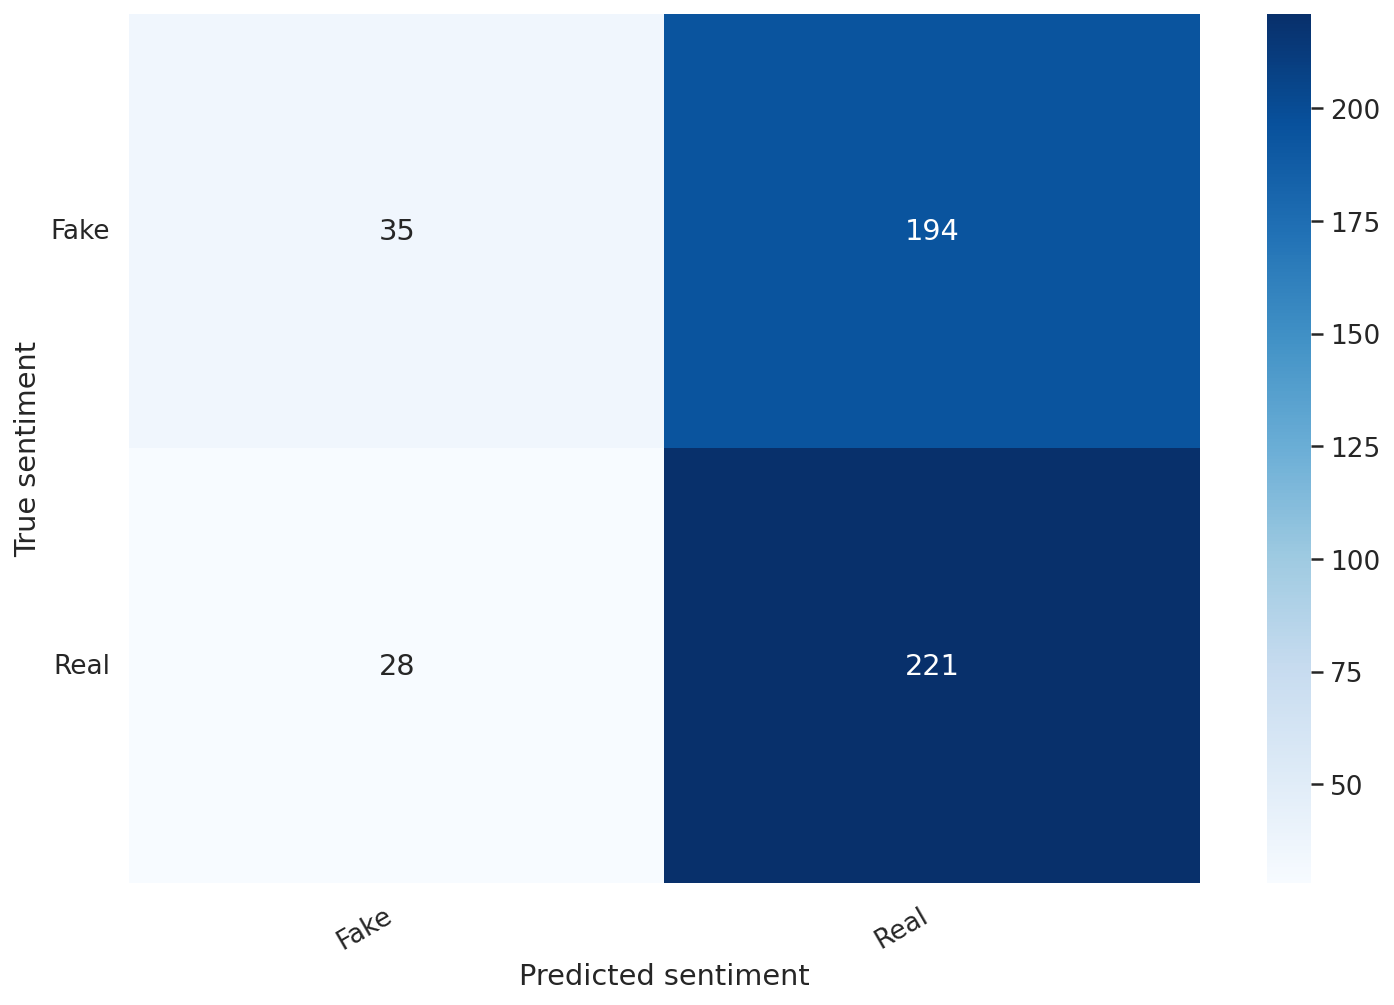

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Implementation with our DATA

In [ ]:
ourDatasetTweets = pd.read_excel('retweets.xlsx')
ourDatasetTweets['numLabel'] = 10
ourDatasetTweets = ourDatasetTweets.rename(columns={'Retweet Content': 'title'})
ourDatasetTweets = ourDatasetTweets.rename(columns={'Author': 'Origin Users'})

In [ ]:
#ourDatasetRetweets = pd.read_excel('tweets_from_labelled_users.xlsx',sheet_name='Retweets')
#ourDatasetRetweets['numLabel'] = 10
#ourDatasetRetweets = ourDatasetRetweets.rename(columns={'Retweet Text': 'title'})
#ourDatasetRetweets

In [ ]:
#ourDatasetTweets = pd.read_excel('../Twitter_Sentiment_Project/dataset/JustTweetsFromOriginUsers.xlsx',sheet_name='tweets')
#ourDatasetTweets['numLabel'] = 10
#ourDatasetTweets = ourDatasetTweets.rename(columns={'Tweet Text': 'title'})
#ourDatasetTweets = ourDatasetTweets.rename(columns={'Tweet Author': 'Origin Users'})
#ourDatasetTweets

In [ ]:
ourDatasetTweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tweet ID      945 non-null    int64 
 1   title         945 non-null    object
 2   Origin Users  945 non-null    object
 3   Follower      945 non-null    object
 4   numLabel      945 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


In [ ]:
class GPReviewOurDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_ourdata_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewOurDataset(
    reviews=df.title.to_numpy(),
    targets=df.numLabel.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
def get_ourpredictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
ourDatasetTweets

,Tweet ID,title,Origin Users,Follower,numLabel
0,1597654448842711040,"RT @WhiteHouse: Gas Update:\n\nToday, gas pric...",WhiteHouse,focusonamerica,10
1,1597651840711229440,"RT @WhiteHouse: Deck the Halls! Today, @FLOTUS...",WhiteHouse,focusonamerica,10
2,1597346891209097224,RT @WhiteHouse: President Biden signed the CHI...,WhiteHouse,focusonamerica,10
3,1597321671807045632,RT @WhiteHouse: Tune in for a briefing with Pr...,WhiteHouse,focusonamerica,10
4,1597307649607225344,RT @WhiteHouse: President Biden has taken more...,WhiteHouse,focusonamerica,10
...,...,...,...,...,...
940,1588635573476016130,"RT @HillaryClinton: If Republicans take power,...",HillaryClinton,JoJoFromJerz,10
941,1588251283789852674,RT @HillaryClinton: Let's be clear about the s...,HillaryClinton,JoJoFromJerz,10
942,1588152991160344576,RT @HillaryClinton: They're looking to impose ...,HillaryClinton,JoJoFromJerz,10
943,1586775082227179521,RT @HillaryClinton: The Republican Party and i...,HillaryClinton,JoJoFromJerz,10


In [ ]:
# create data loaders
our_data_loader = create_data_loader(ourDatasetTweets, tokenizer, MAX_LEN, BATCH_SIZE)
#our_data_loader_retweeters = create_data_loader(ourDatasetRetweets, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# get predictions for origin users tweets
OU_review_texts, OU_predictions, OU_prediction_probs, OU_real_values = get_predictions(model,our_data_loader)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [ ]:
# get predictions for retweeters retweets
#RT_review_texts, RT_predictions, RT_prediction_probs, RT_real_values = get_predictions(model,our_data_loader_retweeters)

NameError: ignored

In [ ]:
OU_predictions

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,

In [ ]:
# Add predictions to dataset
type(OU_predictions)

torch.Tensor

In [ ]:
# change predictions type to array
OU_predictions_np = OU_predictions.numpy()
#RT_predictions_np = RT_predictions.numpy()

In [ ]:
type(OU_predictions_np)

NameError: ignored

In [ ]:
OU_predictions_np

NameError: ignored

In [ ]:
#preds_tweets = []
def day_Res(result):
  preds_tweets = []
  for x in result:
      if x == 0:
        preds_tweets.append('Fake')
      if x == 1:
        preds_tweets.append('Real')
      else:
        "it doesnt have a label"

  return preds_tweets

In [ ]:
# Get labels for prediction result, for both datasets
OU_result_label = day_Res(OU_predictions)
#RT_result_label = day_Res(RT_predictions_np)

In [ ]:
OU_preds_tweets = pd.DataFrame(OU_result_label, columns =['prediction'])
OU_preds_tweets

,prediction
0,Real
1,Real
2,Real
3,Real
4,Real
...,...
940,Real
941,Real
942,Real
943,Fake


In [ ]:
#RT_preds_tweets = pd.DataFrame(RT_result_label, columns =['prediction'])
#RT_preds_tweets

In [ ]:
OU_preds_tweets.reset_index(drop=True, inplace=True)
ourDatasetTweets.reset_index(drop=True, inplace=True)
OU_prediction_retweets = pd.concat([ourDatasetTweets,OU_preds_tweets],1)

<ipython-input-62-201a59b202b9>:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  OU_prediction_retweets = pd.concat([ourDatasetTweets,OU_preds_tweets],1)


In [ ]:
OU_prediction_retweets

NameError: ignored

In [ ]:
#OU_prediction_retweets.to_excel("OU_prediction_retweets.xlsx",sheet_name='labeled')

In [ ]:
#RT_preds_tweets.reset_index(drop=True, inplace=True)
#ourDatasetRetweets.reset_index(drop=True, inplace=True)
#RT_prediction_retweets = pd.concat([ourDatasetRetweets,RT_preds_tweets],1)

In [ ]:
#RT_prediction_retweets

In [ ]:
#RT_prediction_retweets.to_excel("RT_prediction_retweets.xlsx",sheet_name='labeled')

In [ ]:
# Validate the results to check if the labels are not all the same
print("Summary for Retweet: ")
#print(pd.value_counts(RT_prediction_retweets["prediction"]))
print("Summary for Origin Users: ")
print(pd.value_counts(OU_prediction_retweets["prediction"]))

Summary for Retweet: 
Summary for Origin Users: 
Real    770
Fake    175
Name: prediction, dtype: int64


## Probabilities

In [ ]:
Origin_Users_Handles = OU_prediction_retweets['Origin Users'].unique()
Origin_Users_Handles

array(['WhiteHouse', 'HillaryClinton', 'JoJoFromJerz', 'POTUS'],
      dtype=object)

In [ ]:
# Probability of origin user posting a fake tweet
# get each tweet from origin user and count them
summary = []
for i in range(len(Origin_Users_Handles)):
  count = 0
  count_fake = 0
  for index, row in OU_prediction_retweets.iterrows():
    if row['Origin Users'] == Origin_Users_Handles[i]:
      count += 1
    if row['prediction'] == 'Fake' and row['Origin Users'] == Origin_Users_Handles[i]:
      count_fake += 1
    if count > 0 :
      probability = count_fake / count
    else:
     probability = 0
  summary.append([count,count_fake,probability,Origin_Users_Handles[i]])

summary

[[501, 58, 0.1157684630738523, 'WhiteHouse'],
 [13, 4, 0.3076923076923077, 'HillaryClinton'],
 [263, 71, 0.26996197718631176, 'JoJoFromJerz'],
 [168, 42, 0.25, 'POTUS']]

In [ ]:
summary = pd.DataFrame(summary, columns=['number of tweets','number of fake tweets','probability','origin user handle'])
summary

,number of tweets,number of fake tweets,probability,origin user handle
0,501,58,0.115768,WhiteHouse
1,13,4,0.307692,HillaryClinton
2,263,71,0.269962,JoJoFromJerz
3,168,42,0.250000,POTUS


In [ ]:
print(pd.value_counts(summary["probability"]))

0.115768    1
0.307692    1
0.269962    1
0.250000    1
Name: probability, dtype: int64


In [ ]:
summary.to_csv("lebelled_Users_Probability.csv",index=False)

In [ ]:
fake_probability = []*945
for i,j in ourDatasetTweets.iterrows():
    for k,h in summary.iterrows():
      if j['Origin Users'] == h['origin user handle']:
        fake_probability.append(h['probability'])
fake_probability

[0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630738523,
 0.1157684630

In [ ]:
fake_probability = pd.DataFrame(fake_probability)
prob_concat = pd.concat([ourDatasetTweets,fake_probability],axis=1,ignore_index=True)
prob_concat = prob_concat.reset_index()
prob_concat

,index,0,1,2,3,4,5
0,0,1597654448842711040,"RT @WhiteHouse: Gas Update:\n\nToday, gas pric...",WhiteHouse,focusonamerica,10,0.115768
1,1,1597651840711229440,"RT @WhiteHouse: Deck the Halls! Today, @FLOTUS...",WhiteHouse,focusonamerica,10,0.115768
2,2,1597346891209097224,RT @WhiteHouse: President Biden signed the CHI...,WhiteHouse,focusonamerica,10,0.115768
3,3,1597321671807045632,RT @WhiteHouse: Tune in for a briefing with Pr...,WhiteHouse,focusonamerica,10,0.115768
4,4,1597307649607225344,RT @WhiteHouse: President Biden has taken more...,WhiteHouse,focusonamerica,10,0.115768
...,...,...,...,...,...,...,...
940,940,1588635573476016130,"RT @HillaryClinton: If Republicans take power,...",HillaryClinton,JoJoFromJerz,10,0.307692
941,941,1588251283789852674,RT @HillaryClinton: Let's be clear about the s...,HillaryClinton,JoJoFromJerz,10,0.307692
942,942,1588152991160344576,RT @HillaryClinton: They're looking to impose ...,HillaryClinton,JoJoFromJerz,10,0.307692
943,943,1586775082227179521,RT @HillaryClinton: The Republican Party and i...,HillaryClinton,JoJoFromJerz,10,0.307692


In [ ]:
prob_concat = prob_concat.set_axis(["index","Tweet ID", "title", "Origin Users","Follower","numLabel","probability"], axis=1)

In [ ]:
prob_concat

,index,Tweet ID,title,Origin Users,Follower,numLabel,probability
0,0,1597654448842711040,"RT @WhiteHouse: Gas Update:\n\nToday, gas pric...",WhiteHouse,focusonamerica,10,0.115768
1,1,1597651840711229440,"RT @WhiteHouse: Deck the Halls! Today, @FLOTUS...",WhiteHouse,focusonamerica,10,0.115768
2,2,1597346891209097224,RT @WhiteHouse: President Biden signed the CHI...,WhiteHouse,focusonamerica,10,0.115768
3,3,1597321671807045632,RT @WhiteHouse: Tune in for a briefing with Pr...,WhiteHouse,focusonamerica,10,0.115768
4,4,1597307649607225344,RT @WhiteHouse: President Biden has taken more...,WhiteHouse,focusonamerica,10,0.115768
...,...,...,...,...,...,...,...
940,940,1588635573476016130,"RT @HillaryClinton: If Republicans take power,...",HillaryClinton,JoJoFromJerz,10,0.307692
941,941,1588251283789852674,RT @HillaryClinton: Let's be clear about the s...,HillaryClinton,JoJoFromJerz,10,0.307692
942,942,1588152991160344576,RT @HillaryClinton: They're looking to impose ...,HillaryClinton,JoJoFromJerz,10,0.307692
943,943,1586775082227179521,RT @HillaryClinton: The Republican Party and i...,HillaryClinton,JoJoFromJerz,10,0.307692


In [ ]:
trust_worthiness = pd.read_excel("RealNetwork_For_New_tw_ti_V2.xlsx")
trust_worthiness

,User/follower Network Number,Total Number of retweets,Cant of RT from Author,User/Follower,Author,user/ follower TrustWorthiness,user/ follower Trustingness
0,user 0,NaN,NaN,POTUS,NaN,0.653319,0.009182
1,user 2,3001.0,468.0,focusonamerica,WhiteHouse,0.000015,0.172448
2,user 3,831.0,4.0,HillaryClinton,WhiteHouse,0.732342,0.335715
3,user 3,831.0,8.0,HillaryClinton,POTUS,0.732342,0.335715
4,user 5,1078.0,17.0,JoJoFromJerz,WhiteHouse,0.016951,0.595552
5,user 5,1078.0,48.0,JoJoFromJerz,POTUS,0.016951,0.595552
6,user 5,1078.0,12.0,JoJoFromJerz,HillaryClinton,0.016951,0.595552
7,user 6,3122.0,2.0,juyi_boo,HillaryClinton,0.000004,0.600290
8,user 6,3122.0,263.0,juyi_boo,JoJoFromJerz,0.000004,0.600290
9,user 1,304.0,92.0,WhiteHouse,POTUS,0.191214,0.172448


In [ ]:
reliability_score = []

for i,j in prob_concat.iterrows():
    for h,k in trust_worthiness.iterrows():
      if j['Follower'] == k['User/Follower']:
        score = k['user/ follower TrustWorthiness'] * (1 - j['probability'])
        reliability_score.append(score)

In [ ]:
len(reliability_score)

1406

In [ ]:
reliability_score = pd.DataFrame(reliability_score)
final_reliability = pd.concat([prob_concat,reliability_score],axis=1)
final_reliability = final_reliability.reset_index()



In [ ]:
final_reliability[0:942].to_csv("tweets_with_reliability.csv")

In [ ]:
# probability for next level of users
#next_lvl_Followers_Handles = RT_prediction_retweets['Follower'].unique()
#next_lvl_Followers_Handles

In [ ]:
#next_lvl_Users_Handles = RT_prediction_retweets['Author/Origin User'].unique()
#next_lvl_Users_Handles

In [ ]:
"""summaryNextLevels = []
for i in range(len(next_lvl_Followers_Handles)):
  for u in range(len(next_lvl_Users_Handles)):
    RTcount = 0
    RTcount_fake = 0
    for index, row in RT_prediction_retweets.iterrows():
      if row['Follower'] == next_lvl_Followers_Handles[i] and row['Author/Origin User'] == next_lvl_Users_Handles[u]:
        RTcount += 1
      if row['prediction'] == 'Fake' and row['Follower'] == next_lvl_Followers_Handles[i] and row['Author/Origin User'] == next_lvl_Users_Handles[u]:
        RTcount_fake += 1
      if RTcount > 0 :
        probability = RTcount_fake / RTcount
      else:
        probability = 0
    summaryNextLevels.append([RTcount,RTcount_fake,probability,next_lvl_Followers_Handles[i],next_lvl_Users_Handles[u]])

summaryNextLevels"""

In [ ]:
#summaryNextLevels = pd.DataFrame(summaryNextLevels, columns=['number of tweets','number of fake tweets','probability','follower','origin user handle'])
#summaryNextLevels

In [ ]:
#summaryNextLevels.info()

In [ ]:
# Delete 0 in the final result
#summaryNextLevels = summaryNextLevels.drop(summaryNextLevels[(summaryNextLevels['number of tweets'] == 0) & (summaryNextLevels['number of fake tweets'] == 0) & (summaryNextLevels['probability'] == 0) ].index)

In [ ]:
#summaryNextLevels = summaryNextLevels.reset_index(drop=True)

In [ ]:
#summaryNextLevels

In [ ]:
#summaryNextLevels.info()

In [ ]:
#print(pd.value_counts(summaryNextLevels["probability"]))

### Final probability

In [ ]:
#final_prob_df = pd.merge(summaryNextLevels, summary, how='left', left_on = 'origin user handle', right_on = 'origin user handle')
#final_prob_df

In [ ]:
#final_prob_df.to_excel("final_prob_df.xlsx",sheet_name='labeled')

In [ ]:
#final_prob_df = final_prob_df.fillna(0)

In [ ]:
#final_prob_df['final probability'] = final_prob_df['probability_x'] * final_prob_df['probability_y']
#final_prob_df

In [ ]:
#final_prob_df.info()

In [ ]:
#final_prob_df.drop(['number of tweets_x', 'number of fake tweets_x','probability_x','number of tweets_y','number of fake tweets_y','probability_y'], axis=1, inplace=True)

In [ ]:
#final_prob_df

In [ ]:
#print(pd.value_counts(final_prob_df["final probability"]))

In [ ]:
# Delete 0 in the final result
#df = final_prob_df.drop(final_prob_df[final_prob_df['final probability'] == 0].index)

In [ ]:
#df = df.reset_index(drop=True)

In [ ]:
#df

In [ ]:
#final_prob_df.info()

In [ ]:
print(pd.value_counts(final_prob_df["final probability"]))

In [ ]:
# file to send to Smita
#final_prob_df.to_csv(r'Downloads/RetweetsProbability.csv',index=False)

In [ ]:
# file to send to Smita
#summary.to_csv("Downloads/Origin_Users_Probability.csv",index=False)